In [1]:
!pip list

Package                                  Version               Editable project location
---------------------------------------- --------------------- -------------------------
absl-py                                  1.4.0
accelerate                               0.22.0
access                                   1.1.9
affine                                   2.4.0
aiobotocore                              2.5.4
aiofiles                                 22.1.0
aiohttp                                  3.8.4
aiohttp-cors                             0.7.0
aioitertools                             0.11.0
aiorwlock                                1.3.0
aiosignal                                1.3.1
aiosqlite                                0.19.0
albumentations                           1.3.1
alembic                                  1.12.0
altair                                   5.1.1
annotated-types                          0.5.0
annoy                                    1.17.3
ansiwrap         

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def load_video(path:str) -> List[float]:
    cap=cv2.VideoCapture(path)
    frames=[]
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame=tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean=tf.math.reduce_mean(frames)
    std=tf.math.reduce_std(tf.cast(frames,tf.float32))
    return tf.cast((frames-mean),tf.float32)/std

In [4]:
path="/kaggle/input/lipreading/data/s1/bbaf2n.mpg"
value=load_video(path)
value

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[1.4991664 ],
         [1.4991664 ],
         [1.4616872 ],
         ...,
         [0.41227075],
         [0.41227075],
         [0.41227075]],

        [[1.4991664 ],
         [1.4991664 ],
         [1.4616872 ],
         ...,
         [0.41227075],
         [0.41227075],
         [0.41227075]],

        [[1.4616872 ],
         [1.4616872 ],
         [1.4991664 ],
         ...,
         [0.33731243],
         [0.33731243],
         [0.33731243]],

        ...,

        [[1.0494164 ],
         [1.0494164 ],
         [1.0119373 ],
         ...,
         [0.11243747],
         [0.11243747],
         [0.07495832]],

        [[1.0494164 ],
         [1.0494164 ],
         [1.0119373 ],
         ...,
         [0.11243747],
         [0.07495832],
         [0.07495832]],

        [[1.0494164 ],
         [1.0494164 ],
         [1.0119373 ],
         ...,
         [0.07495832],
         [0.07495832],
         [0.03747916]]],


  

In [5]:
#ADDITIONAL FUNCTION I MADE TO GET vocab WHICH IS A PARAMETER FOR THE CHAR_TO_NUM FUNCTION
def get_vocab():
    vocab=[]
    directory="/kaggle/input/lipreading/data/alignments/s1"
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        with open(file_path, 'r') as f:
            lines=f.readlines()
            for line in lines:
                line=line.split()
                vocab.append(line[2])
    return vocab       

In [6]:
vocab=np.unique(get_vocab())

In [7]:
print(vocab)

['a' 'again' 'at' 'b' 'bin' 'blue' 'by' 'c' 'd' 'e' 'eight' 'f' 'five'
 'four' 'g' 'green' 'h' 'i' 'in' 'j' 'k' 'l' 'lay' 'm' 'n' 'nine' 'now'
 'o' 'one' 'p' 'place' 'please' 'q' 'r' 'red' 's' 'set' 'seven' 'sil'
 'six' 'soon' 'sp' 't' 'three' 'two' 'u' 'v' 'white' 'with' 'x' 'y' 'z'
 'zero']


In [8]:
char_to_num= tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char=tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="",invert=True)

In [9]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines=f.readlines()
        
            
        
    tokens=[]
    for line in lines:
        line=line.split()
        if line[2]!= 'sil':
            tokens= [*tokens,' ',line[2]]
        
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding='UTF-8'),(-1)))[1:]

In [10]:
path="/kaggle/input/lipreading/data/alignments/s1/bbaf2n.align"
load_alignments(path)


<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 4, 18, 25,  0,  4, 22, 46, 10,  0,  1, 43,  0, 12,  0, 43,  0, 28,
        0, 25, 28,  0])>

In [11]:
def load_data(path:str):
    path=bytes.decode(path.numpy())
    file_name=path.split('/')[-1].split('.')[0]
    video_path=os.path.join('/kaggle/input/lipreading/data','s1',f'{file_name}.mpg')
    alignment_path=os.path.join('/kaggle/input/lipreading/data','alignments','s1',f'{file_name}.align')
    frames=load_video(video_path)
    alignments=load_alignments(alignment_path)
    
    return frames,alignments

In [12]:
#TESTING THE OUTPUT FOR A SAMPLE FILE
path="/kaggle/input/lipreading/data/s1/bbaf2n.mpg"
frames, alignments=load_data(tf.convert_to_tensor(path))
print("frames:",frames)
print("alignments:",alignments)

frames: tf.Tensor(
[[[[1.4991664 ]
   [1.4991664 ]
   [1.4616872 ]
   ...
   [0.41227075]
   [0.41227075]
   [0.41227075]]

  [[1.4991664 ]
   [1.4991664 ]
   [1.4616872 ]
   ...
   [0.41227075]
   [0.41227075]
   [0.41227075]]

  [[1.4616872 ]
   [1.4616872 ]
   [1.4991664 ]
   ...
   [0.33731243]
   [0.33731243]
   [0.33731243]]

  ...

  [[1.0494164 ]
   [1.0494164 ]
   [1.0119373 ]
   ...
   [0.11243747]
   [0.11243747]
   [0.07495832]]

  [[1.0494164 ]
   [1.0494164 ]
   [1.0119373 ]
   ...
   [0.11243747]
   [0.07495832]
   [0.07495832]]

  [[1.0494164 ]
   [1.0494164 ]
   [1.0119373 ]
   ...
   [0.07495832]
   [0.07495832]
   [0.03747916]]]


 [[[1.424208  ]
   [1.424208  ]
   [1.424208  ]
   ...
   [0.33731243]
   [0.33731243]
   [0.33731243]]

  [[1.424208  ]
   [1.424208  ]
   [1.424208  ]
   ...
   [0.33731243]
   [0.33731243]
   [0.33731243]]

  [[1.424208  ]
   [1.424208  ]
   [1.424208  ]
   ...
   [0.29983327]
   [0.29983327]
   [0.29983327]]

  ...

  [[1.0494164 ]
   [

**VISUAL ANALYSIS**


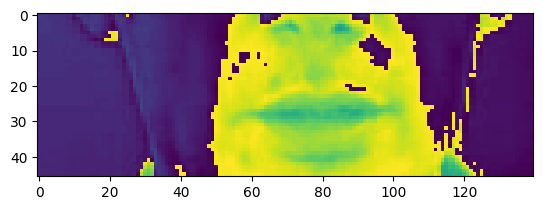

In [13]:
plt.imshow(frames[15])

**Splitting data into train and test and validation sets**

In [14]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [15]:
data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
data = data.shuffle(500,reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# # ADDED DOR SPLIT
train = data.take(450)
test = data.skip(450)

In [16]:
frames, alighnments = data.as_numpy_iterator().next()

In [17]:
sample = data.as_numpy_iterator()

In [18]:
val = sample.next();val[0]

array([[[[[1.3790182 ],
          [1.3790182 ],
          [1.3407121 ],
          ...,
          [9.729739  ],
          [0.15322424],
          [0.15322424]],

         [[1.3790182 ],
          [1.3790182 ],
          [1.3407121 ],
          ...,
          [0.        ],
          [0.15322424],
          [0.15322424]],

         [[1.2641    ],
          [1.2641    ],
          [1.2641    ],
          ...,
          [0.15322424],
          [0.11491818],
          [0.11491818]],

         ...,

         [[0.9576515 ],
          [0.9576515 ],
          [0.9576515 ],
          ...,
          [9.691433  ],
          [9.691433  ],
          [9.691433  ]],

         [[0.91934544],
          [0.91934544],
          [0.91934544],
          ...,
          [9.538209  ],
          [9.614821  ],
          [9.614821  ]],

         [[0.91934544],
          [0.91934544],
          [0.91934544],
          ...,
          [9.538209  ],
          [9.538209  ],
          [9.538209  ]]],


        [[[1.3407

**MODEL BUILDING**

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D,Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

**Defining callbacks**

In [20]:
def scheduler(epoch,lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [21]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

**Defining Loss function**

In [22]:
def CTCLoss(y_true,y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1],dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1],dtype="int64")
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

**Model building**

In [23]:

model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))


**TRAINING THE MODELS**

In [24]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)

In [25]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [26]:
#model.fit(train,validation_data=test,epochs=100,callbacks=[checkpoint_callback,schedule_callback,example_callback])

LOADING THE MODEL AND MAKING PREDICTIONS

In [27]:
import joblib

In [28]:
loaded_model=joblib.load('/kaggle/input/trained-lip-reading-model/trained_lip_reading_model.pkl')

In [29]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [30]:
test_data=test.as_numpy_iterator()

In [31]:
sample=test_data.next()

[mpeg1video @ 0x7c8ad0033bc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7c8ad0033bc0] Warning MVs not available


In [32]:
yhat=loaded_model.predict(sample[0])

1/1 [==============================] - 6s 6s/step


In [33]:
print('~'*100,'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'sethiteinbthreesoonplacegreenbyetono'>]

In [34]:
decoded=tf.keras.backend.ctc_decode(yhat,input_length=[75,75],greedy=True)[0][0].numpy()

In [35]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'sethiteinhresoon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'placegrenbyono'>]

In [36]:
sample=load_data(tf.convert_to_tensor('/kaggle/input/lipreading/data/s1/bbaf5a.mpg'))


In [37]:
print('~'*100,'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'binblueatffiveagain'>]

In [38]:
yhat=loaded_model.predict(tf.expand_dims(sample[0],axis=0))

1/1 [==============================] - 1s 501ms/step


In [39]:
decoded=tf.keras.backend.ctc_decode(yhat,input_length=[75],greedy=True)[0][0].numpy()

In [40]:
print('~'*100,'PREDICTIONS')
prediction=[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]
print(prediction)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS
[<tf.Tensor: shape=(), dtype=string, numpy=b'binblueatfiveagain'>]


SPLITTING THE PREDICTION INTO SEPERATE WORDS

In [41]:
print(vocab)

['a' 'again' 'at' 'b' 'bin' 'blue' 'by' 'c' 'd' 'e' 'eight' 'f' 'five'
 'four' 'g' 'green' 'h' 'i' 'in' 'j' 'k' 'l' 'lay' 'm' 'n' 'nine' 'now'
 'o' 'one' 'p' 'place' 'please' 'q' 'r' 'red' 's' 'set' 'seven' 'sil'
 'six' 'soon' 'sp' 't' 'three' 'two' 'u' 'v' 'white' 'with' 'x' 'y' 'z'
 'zero']


In [42]:
vocab_words=[]
for i in vocab:
    if len(i)>=2:
        vocab_words.append(i)
        

In [43]:
print(vocab_words)

['again', 'at', 'bin', 'blue', 'by', 'eight', 'five', 'four', 'green', 'in', 'lay', 'nine', 'now', 'one', 'place', 'please', 'red', 'set', 'seven', 'sil', 'six', 'soon', 'sp', 'three', 'two', 'white', 'with', 'zero']


In [44]:
prediction_str = prediction[0].numpy().decode('utf-8')

In [45]:
predicted_words=[]
current_word=''
for char in prediction_str:
    current_word+=char
    if current_word in vocab_words:
        predicted_words.append(current_word)
        current_word=''
predicted_sentence= ' '.join(predicted_words)
print(predicted_sentence)

bin blue at five again
